<a href="https://colab.research.google.com/github/fv-123/LSTM-MLP-MeanVariance-project/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from scipy.stats import zscore, kurtosis, skew
from custom_functions import clip_outliers, compute_latest_corr_matrix, compute_pca_variance_series, compute_rolling_portfolio_volatility, describe_shape
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import copy
from config import CONFIG

In [ ]:
df = pd.read_csv("combined_stock_data_wide.csv", parse_dates=["Date"])

# Set datetime index
df.set_index("Date", inplace=True)


df.dropna(inplace=True) #dropping all nulls

# Extract closing prices
close_cols = [col for col in df.columns if col.endswith("_Close") and "Adj" not in col]
volume_cols = [col for col in df.columns if col.endswith("_Volume")]

close_df = df[close_cols]
volume_df = df[volume_cols]

<big>Exploratory Data Analysis + Feature Engineering<big>

HHS.VN_Volume    0
HAH.VN_Volume    0
VCB.VN_Volume    0
VIX.VN_Volume    0
LPB.VN_Volume    0
YEG.VN_Volume    0
dtype: int64


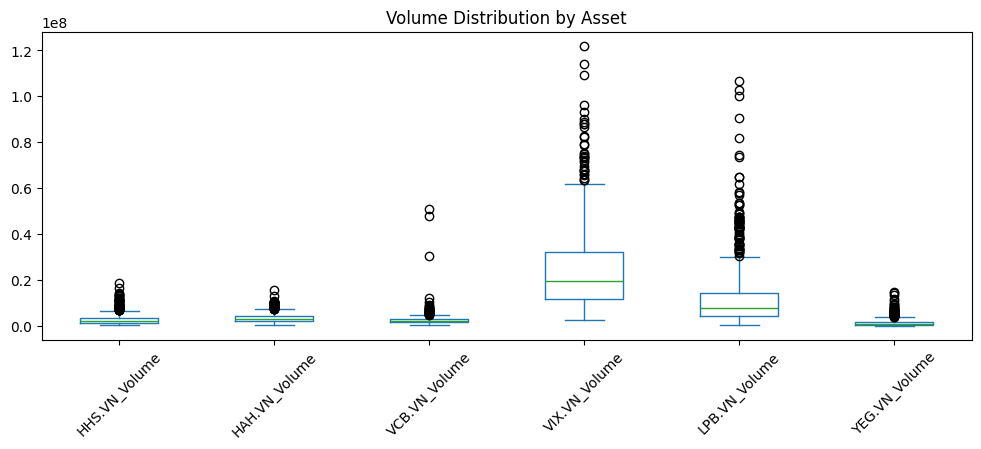

In [ ]:
# Count zero volumes
print((volume_df == 0).sum().sort_values(ascending=False))

# Boxplot to see volume outliers
volume_df.plot(kind='box', figsize=(12, 4), title="Volume Distribution by Asset")
plt.xticks(rotation=45)
plt.show()

LPB, HPG, and VIX has high amount of outliers, and a lot of outliers, so I should not just remove them but rather transform them into logarithm form

In [ ]:
# handling outliers
log_volume = np.log1p(volume_df)
log_volume.columns = [f"{col}_vol" for col in log_volume.columns]

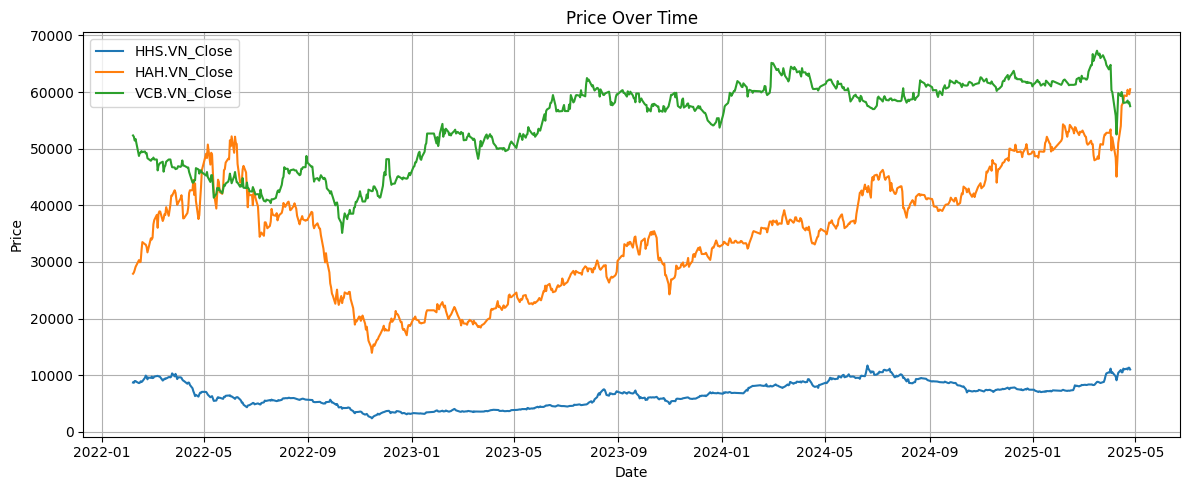

In [ ]:
# Plot raw price to show non-stationarity
plt.figure(figsize=(12, 5))
for col in close_cols[:3]:
    plt.plot(close_df[col], label=col)
plt.title("Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The data is non-stationary, as expected with the nature of stock price, meaning I have to transform it into a close-to-stationary form, which I used log returns

In [ ]:
# Compute raw log returns and keep them separate
raw_log_returns = np.log(close_df / close_df.shift(1))

# Create the target BEFORE any other feature engineering
future_returns = raw_log_returns.shift(-1)

# Renaming the columns in future_returns to avoid conflicts
future_returns.columns = ['future_' + col for col in future_returns.columns]

# Apply outlier clipping and drop NA values
future_returns = clip_outliers(future_returns)
future_returns.dropna(inplace=True)

# Feature engineering happens completely separately
log_returns = raw_log_returns.copy()


In [ ]:
# Risk indicator
rolling_std = raw_log_returns.rolling(window=12).std()  # tune
rolling_std = rolling_std.add_suffix('_risk')  # rename cols to avoid collision

# Add it to target
future_risks = rolling_std.shift(-1)
future_risks=future_risks.add_prefix('future_')

future_risks.dropna(inplace=True)

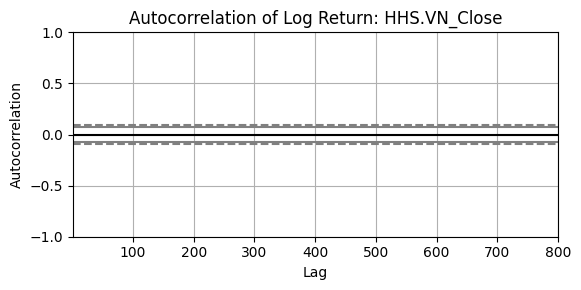

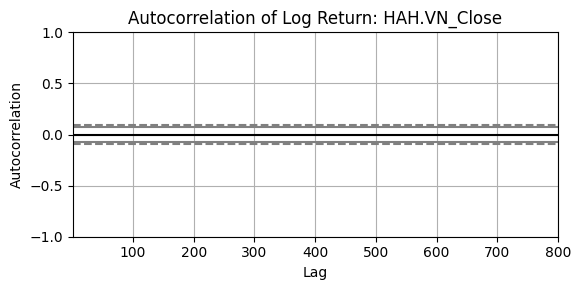

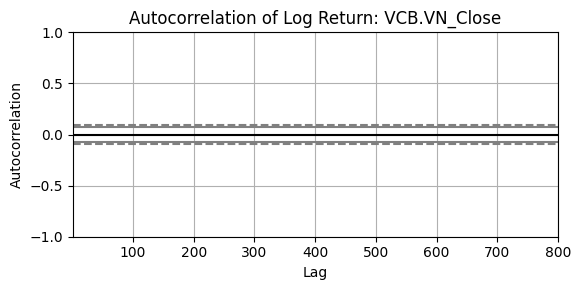

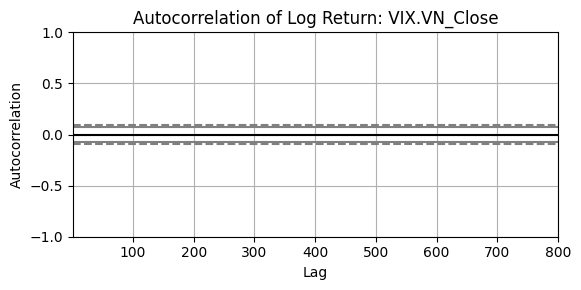

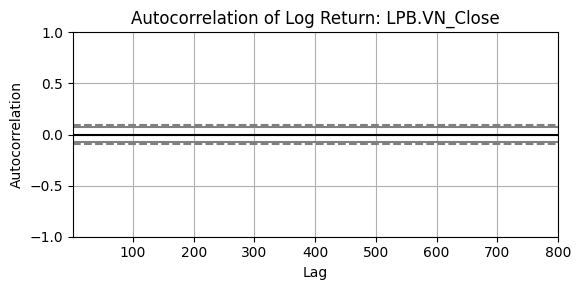

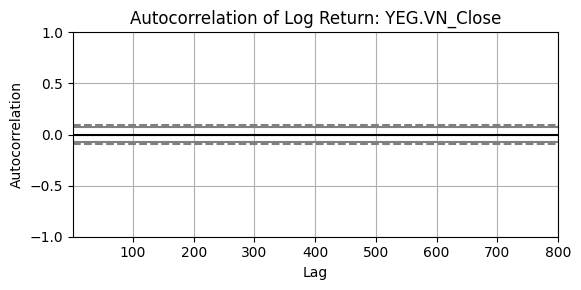

In [ ]:
# autocorrelation of log returns
for col in raw_log_returns.columns:
    plt.figure(figsize=(6, 3))
    autocorrelation_plot(raw_log_returns[col])
    plt.title(f'Autocorrelation of Log Return: {col}')
    plt.tight_layout()
    plt.show()

No autocorrelation, but that doesn't mean we shouldn't add lagged feature or rolling features, because mathematically, autocorrelation only captures linear dependencies, which isn't true with stock data. So I'm going to experiment with many cases with the toggles below

In [ ]:
# --- Toggle which features to include ---
include_lagged_returns = False
include_lagged_volume = False
include_rolling_returns = False
include_rolling_volume = False
include_regime_labels = True
use_one_hot_regime = True  # if False, will use ordinal encoding

This is for turning on or off block (used for adding, removing features)

In [ ]:
# lagged returns
if include_lagged_returns:
    for lag in [1, 2]:
        for col in close_cols:
            log_returns[f"{col}_lag_{lag}"] = log_returns[col].shift(lag)

In [ ]:
# rolling mean/std for log returns
if include_rolling_returns:
    rolling_windows = [15]
    for col in close_cols:
        for w in rolling_windows:
            log_returns[f"{col}_rollmean_{w}"] = log_returns[col].rolling(window=w).mean()

In [ ]:
# Log volume and lagged log volume ---
log_volume = np.log1p(volume_df).diff()
log_volume.dropna(inplace=True) # diff() creates 1 null

if include_lagged_volume:
    for lag in [1, 2, 3]:
        for col in volume_df.columns:
            log_volume[f"{col}_lag_{lag}"] = log_volume[col].shift(lag)

In [ ]:
# rolling mean/std for log volume
if include_rolling_volume:
    for col in volume_df.columns:
        for w in [5, 10, 20]:
            log_volume[f"{col}_rollmean_{w}"] = log_volume[col].rolling(window=w).mean()

In [ ]:
# --- Feature Block: Regime Labeling ---
def label_regime(series, short_window=10, long_window=30):
    short_ma = series.rolling(window=short_window).mean()
    long_ma = series.rolling(window=long_window).mean()
    label = np.where(short_ma > long_ma, "bull",
             np.where(short_ma < long_ma, "bear", "sideway")) # else short_ma==long_ma -> sideway
    return pd.Series(label, index=series.index)

regime_dummies = pd.DataFrame()

if include_regime_labels:
    market_proxy = close_df[close_cols[0]]
    regime_labels = label_regime(market_proxy)

    if use_one_hot_regime:
        regime_dummies = pd.get_dummies(regime_labels, prefix="regime").astype(float)
    else:
        regime_map = {"bear": 0, "sideway": 1, "bull": 2}  # ordinal encoding
        regime_encoded = regime_labels.map(regime_map)
        regime_dummies = regime_encoded.to_frame(name="regime_encoded")

Target Construction


Descriptive stats for future returns (post-clipping):
       future_HHS.VN_Close  future_HAH.VN_Close  future_VCB.VN_Close  \
count           799.000000           799.000000           799.000000   
mean              0.000295             0.000968             0.000135   
std               0.029458             0.029172             0.014138   
min              -0.072510            -0.082279            -0.048359   
25%              -0.011835            -0.013001            -0.007059   
50%               0.000000             0.001211             0.000000   
75%               0.014113             0.015998             0.006708   
max               0.067620             0.067586             0.048008   

       future_VIX.VN_Close  future_LPB.VN_Close  future_YEG.VN_Close  
count           799.000000           799.000000           799.000000  
mean             -0.000439             0.000915            -0.000015  
std               0.032842             0.024425             0.034692  
min         

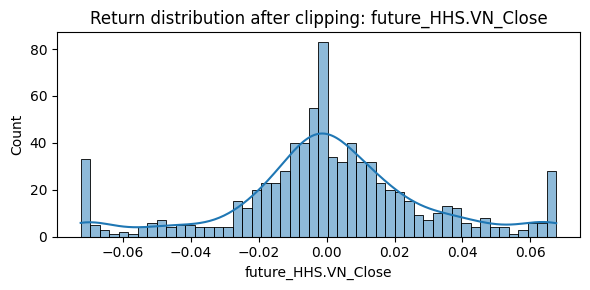

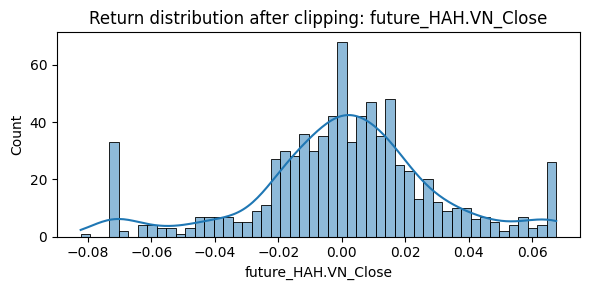

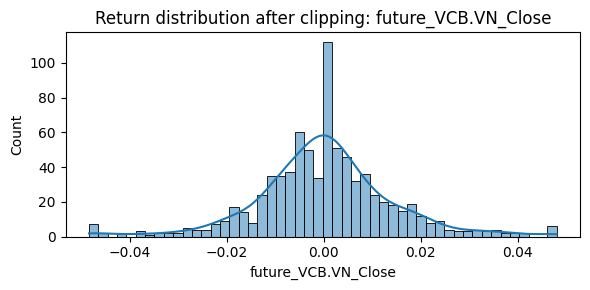

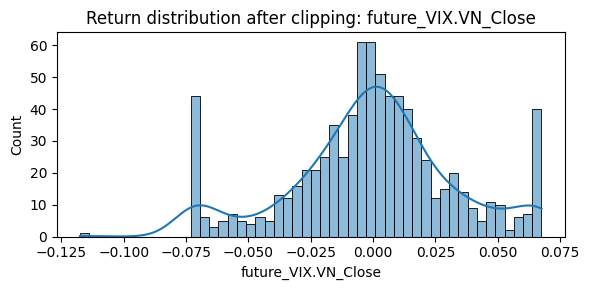

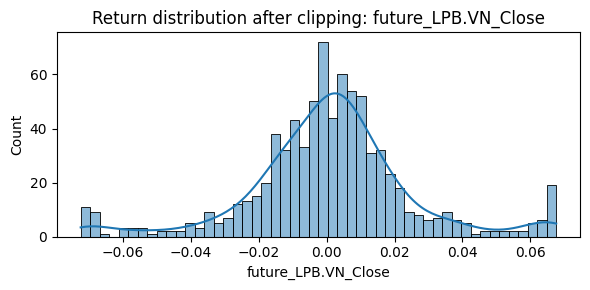

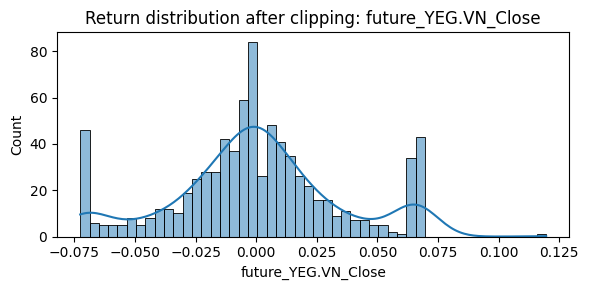

In [ ]:
print("\nDescriptive stats for future returns (post-clipping):")
filtered_cols = [col for col in future_returns.columns if "lag" not in col]
print(future_returns[filtered_cols].describe())

for col in filtered_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(future_returns[col], kde=True, bins=50)
    plt.title(f"Return distribution after clipping: {col}")
    plt.tight_layout()
    plt.show()


The distribution is mostly normal, except for skewness in the tails. However, this is expected and doesn't strictly violate the assumptions of LSTM

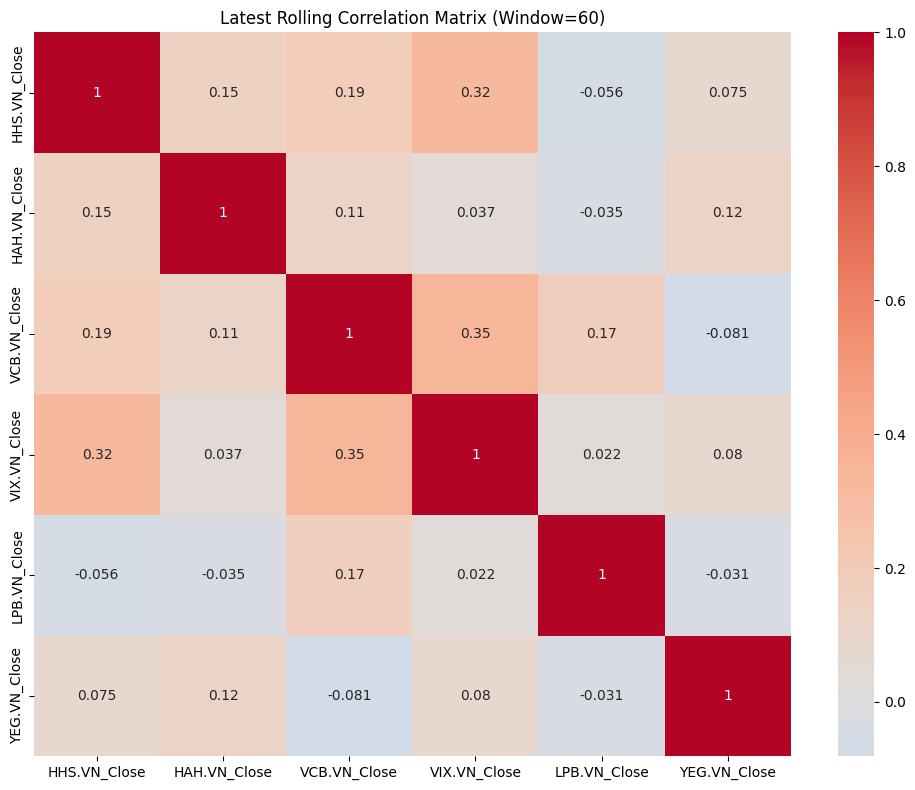

In [ ]:
# Exclude last 10 trading days for correlation analysis because of the recent market crash and we can't see the real correlation between assets
cleaned_df = log_returns.iloc[:-20]
latest_corr = compute_latest_corr_matrix(cleaned_df[close_cols], window=80)

plt.figure(figsize=(10, 8))
sns.heatmap(latest_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Latest Rolling Correlation Matrix (Window=60)")
plt.tight_layout()
plt.show()

The highest positive correlation we see is only 0.42, most of them are close to 0, which is not perfect, but still excellent for allocation